In [1]:
import torch
import numpy as np
import pandas as pd


In [2]:
data = pd.read_csv("dataset/train.csv")

In [3]:
data.head()

,image_id,is_male,left_eye_x,left_eye_y,right_eye_x,right_eye_y,nose_x,nose_y,mouth_left_x,mouth_left_y,mouth_right_x,mouth_right_y
0,0000.jpg,1,152,186,236,183,196,234,158,262,231,260
1,0001.jpg,-1,146,191,232,192,190,229,155,263,228,264
2,0002.jpg,1,157,188,229,188,194,235,164,258,224,257
3,0003.jpg,-1,152,210,232,210,191,248,159,280,222,281
4,0004.jpg,-1,151,189,237,189,192,227,155,254,232,254


In [4]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file).replace(-1,0)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)/255
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
from torch.utils.data import random_split

data = CustomImageDataset('dataset/train.csv','dataset/BitmojiDataset/trainimages')
train_data,test_data = random_split(data,[int(len(data)*0.8),len(data)-int(len(data)*0.8)])


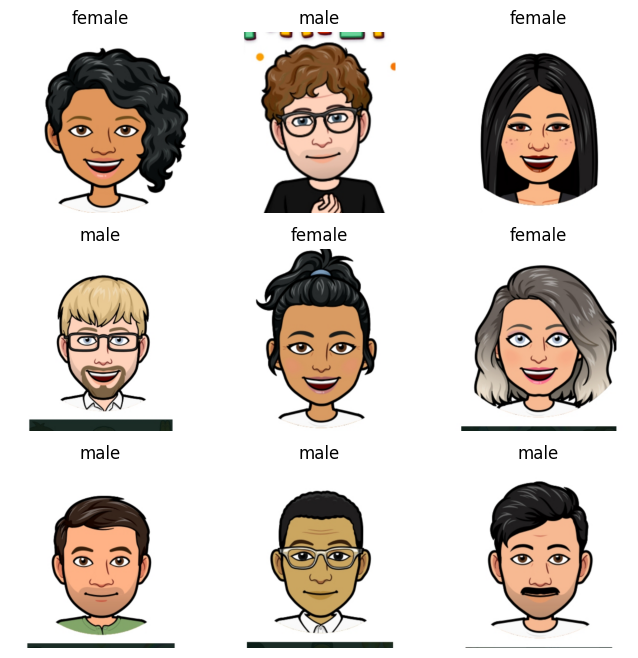

In [6]:
import matplotlib.pyplot as plt

labels_map = {
    0: "female",
    1: "male",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.transpose(0,2).transpose(0,1))
plt.show()

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=400, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=400, shuffle=True)

In [8]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(X.dtype)
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([400, 3, 384, 384])
torch.float32
Shape of y: torch.Size([400]) torch.int64


Feature batch shape: torch.Size([400, 3, 384, 384])
Labels batch shape: torch.Size([400])


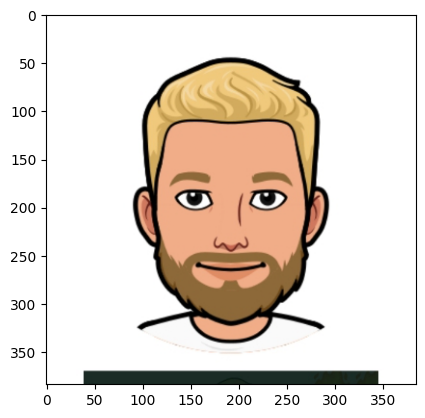

Label: 1


In [9]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.transpose(0,2).transpose(0,1))
plt.show()
print(f"Label: {label}")

In [10]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3,96,11,4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(96,256,5,2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256,384,3),
            nn.ReLU(),
            nn.Conv2d(384,384,3),
            nn.ReLU(),
            nn.Conv2d(384,256,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2304, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (conv): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, 

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [16]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [17]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [18]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.698733  [    0/ 2400]
loss: 0.692692  [  400/ 2400]
loss: 0.692347  [  800/ 2400]
loss: 0.691652  [ 1200/ 2400]
loss: 0.695925  [ 1600/ 2400]
loss: 0.692261  [ 2000/ 2400]
Test Error: 
 Accuracy: 52.7%, Avg loss: 0.691354 

Epoch 2
-------------------------------
loss: 0.697674  [    0/ 2400]
loss: 0.690313  [  400/ 2400]
loss: 0.694598  [  800/ 2400]
loss: 0.686902  [ 1200/ 2400]
loss: 0.692364  [ 1600/ 2400]
loss: 0.689789  [ 2000/ 2400]
Test Error: 
 Accuracy: 52.7%, Avg loss: 0.691784 

Epoch 3
-------------------------------
loss: 0.690963  [    0/ 2400]
loss: 0.688549  [  400/ 2400]
loss: 0.692197  [  800/ 2400]
loss: 0.690166  [ 1200/ 2400]
loss: 0.694700  [ 1600/ 2400]
loss: 0.694422  [ 2000/ 2400]
Test Error: 
 Accuracy: 52.7%, Avg loss: 0.691194 

Epoch 4
-------------------------------
loss: 0.684918  [    0/ 2400]
loss: 0.689800  [  400/ 2400]
loss: 0.695116  [  800/ 2400]
loss: 0.694810  [ 1200/ 2400]
loss: 0.691037  [ 1600/ 